# Stochastic Galactic Ray Environment

GCRs composition: ~87% protons, 12% $\alpha$ and ~1% heavy ions; flux anticorrelates with solar activity

In [11]:
import Pkg
Pkg.activate("..")
Pkg.status()

  Activating project at `~/Documents/Kaizen/code/space-behaviour`
   Resolving package versions...
    Updating `~/Documents/Kaizen/code/space-behaviour/Project.toml`
⌅ [a98d9a8b] + Interpolations v0.15.1
  No Changes to `~/Documents/Kaizen/code/space-behaviour/Manifest.toml`


Status `~/Documents/Kaizen/code/space-behaviour/Project.toml`
  [46ada45e] Agents v6.2.10
  [336ed68f] CSV v0.10.15
⌃ [13f3f980] CairoMakie v0.13.10
  [a93c6f00] DataFrames v1.7.0
  [0c46a032] DifferentialEquations v7.16.1
  [31c24e10] Distributions v0.25.120
  [587475ba] Flux v0.16.5
  [86223c79] Graphs v1.13.0
⌅ [a98d9a8b] Interpolations v0.15.1
⌅ [ee78f7c6] Makie v0.22.10
  [c3e4b0f8] Pluto v0.20.13
  [7f904dfe] PlutoUI v0.7.68
  [90137ffa] StaticArrays v1.9.14
  [2913bbd2] StatsBase v0.34.5
⌃ [fce5fe82] Turing v0.39.8
Info Packages marked with ⌃ and ⌅ have new versions available. Those with ⌃ may be upgradable, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


##  Toy Model: Simulating Stochastic Arrival

### Using $\lambda$ to generate arrival times

Arrival times are stochastic and independent where inter-arrival times $t_{i}$ follow an exponential distribution

$$
\text{arrival times}\ (\Delta t_{i}) \sim \text{Exp}(\lambda)
$$

####  Sampling particle energy form truncated exponential

$E(\text{GCRs}) \in [E_{\min}, E_{\max}]$ and can be sampled from a truncated exponential $p(E) = \frac{1}{Z}e^{_{E/E_{0}}}$

first we can normalise the PDF by computing 


$$
Z = \int_{E_{\min}}^{E_{\max}} e^{(-E/E_{0})}dE = E_{0}\left( e^{-E_{\min}/E_{0}}  - e^{-E_{\max}/E_{0}}\right) 
$$


therefore the normalised truncated CDF


$$
F(E) = \int_{E_{_{\min}}}^{E}p(x)dx = \frac{E_{0}}{Z}\left( e^{-E_{_{\min}}/E_{0}} - e^{-E/E_{0}} \right) 
$$


i.e the probability the sampled energy < E using which we can calculate the inverse CDF 


$$
E(u) = -E_{0} \cdot \ln\left( e^{-E/E_{0}} - \frac{{F(E) \cdot Z}}{E_{0}} \right)
$$


which tell us *the energy level for a given probability value* $u = F(E)$ which we sampled from the uniform distribution

In [43]:
using Random, Distributions, LinearAlgebra, StaticArrays, StatsBase

λ = 0.02
T_max = 1000.0
typesofparticles = ["proton", "helium", "heavy"]
weights = [0.87, 0.12, 0.01]
E0 = 100.0      
E_min = 10.0
E_max = 1000.0

struct GCRarrival
    t::Float32
    type::String
    energy::Float32
    direction::SVector{3, Float32}
end

# step: simulate interarrival times from Exp
Δts = rand(Exponential(1/λ), 10000)

# step: compute arrival times and keep only those < T_max
times = cumsum(Δts)[cumsum(Δts .<= T_max)]
N = length(times)

# step: simulate energies of arriving particles using inverse CDF
u = rand(N)
a, b = exp(-E_min/E0), exp(-E_max/E0) # constants
energy(u) = -E0 .* log.(a .- u .* (a - b)) # inverse CDF
energies = energy(u)

# step: simulate directions of arriving particles 
ϕs = 2π .* rand(N)
μs = rand(Uniform(-1, 1), N)
θs = acos.(μs)
directions = [SVector{3, Float32}(sin(θ)*cos(ϕ), sin(θ)*sin(ϕ), cos(θ)) for (θ, ϕ) in zip(θs, ϕs)]

# step: simulate particle type
particles = sample(typesofparticles, Weights(weights), N)

# simulation
events = GCRarrival[]
for i in 1:N
    push!(
        events, 
        GCRarrival(
            Float32(times[i]), 
            particles[i], 
            Float32(energies[i]), 
            directions[i]
        )

    )
end

println("Simulated $N arrivals in $T_max seconds")

Simulated 10000 arrivals in 1000.0 seconds


##  Deriving $\lambda$ from GCR flux

$$
\lambda = A \cdot 4\pi \cdot \int_{E_{\text{min}}}^{E_{\text{max}}}\phi(E)dE
$$

where $\phi(E)$ is the GCR flux as recorded by OLTARIS/CREM96

### Defining the shared energy axis

The energy grid will define the energy domain over which simulated flux values are evaluated. We use **logarithmic** spacing so that there are many points at low energies (this is where most particles are)

In [59]:
using LinearAlgebra

Emin = 1.0
Emax = 3.0e4
points = 1000

energy_grid = range(log10(Emin), log10(Emax), length = points)
energies = 10 .^ collect(energy_grid)
first(energies, 5)

5-element Vector{Float64}:
 1.0
 1.0103726992380049
 1.0208529913654918
 1.0314419924111438
 1.0421408299798731

### Composite analytic GCR spectrum (OLTARIS/CREM96 unavailable)

We can define total flux as a weighted sum of species where each component will have differential flux of the form


$$
\phi(E) = A\cdot\left( \frac{E}{E_{0}}\right)^{-\gamma} \cdot e^{-E/E_{0}}
$$

where:

- $A$ is the species specific normalisation constant
- $\gamma$ is the spectral index
- $E_{c}$ is the cutoff energy

the values we use for $\gamma$ and $A$ are based on available literature where we plot flux against energy and fit a linear regression such that

$$
\phi(E) = -\gamma \cdot \log(E) + \log(A)
$$

Reference: 

*O. Adriani et al., PAMELA Measurements of Cosmic-Ray Proton and Helium Spectra.Science332,69-72(2011).DOI:10.1126/science.1199172*

In [29]:
# parameters based on CREAM/AMS-02 measurement
PARTICLE_PARAMS = Dict(
        :proton => (γ = 2.7, cutoff = 1.0e4, A = 1.0),
        :helium => (γ = 2.58, cutoff = 1.0e4, A = 0.1),
        :heavy => (γ = 2.6, cutoff = 1.0e4, A = 0.01),
    )

function flux(particle::Symbol, E_mev::Float64)::Float64

    E0 = 1.0

    @assert haskey(PARTICLE_PARAMS, particle) "Unsupported type: $particle"

    γ, cutoff, A = PARTICLE_PARAMS[particle]

    flux = A * (E_mev/E0) ^ (-γ) * exp(-E_mev/cutoff)

    return flux

end

protonflux = flux.(:proton, E_vals)
heliumflux = flux.(:helium, E_vals)
heavyflux = flux.(:heavy, E_vals)

totalflux = protonflux .+ heliumflux .+ heavyflux

first(totalflux, 5)

flux (generic function with 1 method)

### Computing CDF of flux

We want to map an energy value $E$ to a probability that the particle energy is $\leq E$

$$
F(E_{i}) = \frac{{\int_{E_{_{\min}}}^{E_{i}}\phi(E)dE}}{\int_{E_{_{\min}}}^{E_{_{\max}}}\phi(E)dE}
$$

which we evaluate using the [[trapezoidal-rule]] for approximation

$$
F_{\text{unnormalised}}(E_{j}) = \sum_{k=1}^{j-1} \frac{{\varphi_{k}+\varphi_{k+1}}}{2}\cdot(E_{k+1} - E_{k})
$$


#### Inversion

We then draw $u \sim U(0,1)$ and attempt to find $E$ such that $F(E) = u$ i.e we require $F^{-1}(u) = E$ so we can sample energies from the distribution at random

In [61]:
using Interpolations

function fluxCDFgenerator(E, flux)

    @assert length(E) == length(flux) "Energu grid and flux vector must be of the same length"
    @assert issorted(E) "Energy grid must be in ascending order"

    # step 1: cuulative trapezoidal integration

    ΔE = diff(E)
    trapezoids = cumsum(
    0.5 .* (flux[1:end-1] .+ flux[2:end]) .* ΔE
    )
    trapezoids = [0.0; trapezoids]

    # step 2: normalise CDF

    CDF = trapezoids ./ trapezoids[end]

    # step 3: construct inverse CDF using Interpolator

    CDFinverse = LinearInterpolation(CDF, E, extrapolation_bc = Throw())

    return CDF, CDFinverse

end

fluxCDFgenerator (generic function with 1 method)

In [74]:
# compute flux CDF and the inverse so we can sample the energy of different ions

protonfluxCDF, protonfluxCDFinv = fluxCDFgenerator(
    energies, protonflux
)
heliumfluxCDF, heliumfluxCDFinv = fluxCDFgenerator(
    energies, heliumflux
)
heavyfluxCDF, heavyfluxCDFinv = fluxCDFgenerator(
    energies, heavyflux
)

# energy samples

protonenergies = protonfluxCDFinv.(rand(10000))
heliumenergies = heliumfluxCDFinv.(rand(10000))
heavyenergies = heavyfluxCDFinv.(rand(10000))

nothing

In [68]:
println("Energy range: ", minimum(energies), " → ", maximum(energies))

u = rand(5)
println("Random u: ", u)
println("Mapped E: ", protonfluxCDFinv.(u))

for Etest in [1.0, 2.0, 10.0, 100.0, 1000.0, 10000.0, 20000.0, 30000.0]
    idx = findfirst(>=(Etest), energies)
    println(Etest, " MeV → CDF ≈ ", protonfluxCDF[idx])
end

Energy range: 1.0 → 30000.00000000001
Random u: [0.2250303724199747, 0.22978250957805824, 0.44832246824685396, 0.9751958185586123, 0.8618580400696543]
Mapped E: [1.1618022538346104, 1.1659886121187908, 1.418827460949282, 8.788894858961568, 3.20305785462858]
1.0 MeV → CDF ≈ 0.0
2.0 MeV → CDF ≈ 0.6967365805127582
10.0 MeV → CDF ≈ 0.9803908333932732
100.0 MeV → CDF ≈ 0.9996159260946269
1000.0 MeV → CDF ≈ 0.9999936054158904
10000.0 MeV → CDF ≈ 0.9999999687216512
20000.0 MeV → CDF ≈ 0.9999999977650539
30000.0 MeV → CDF ≈ 1.0


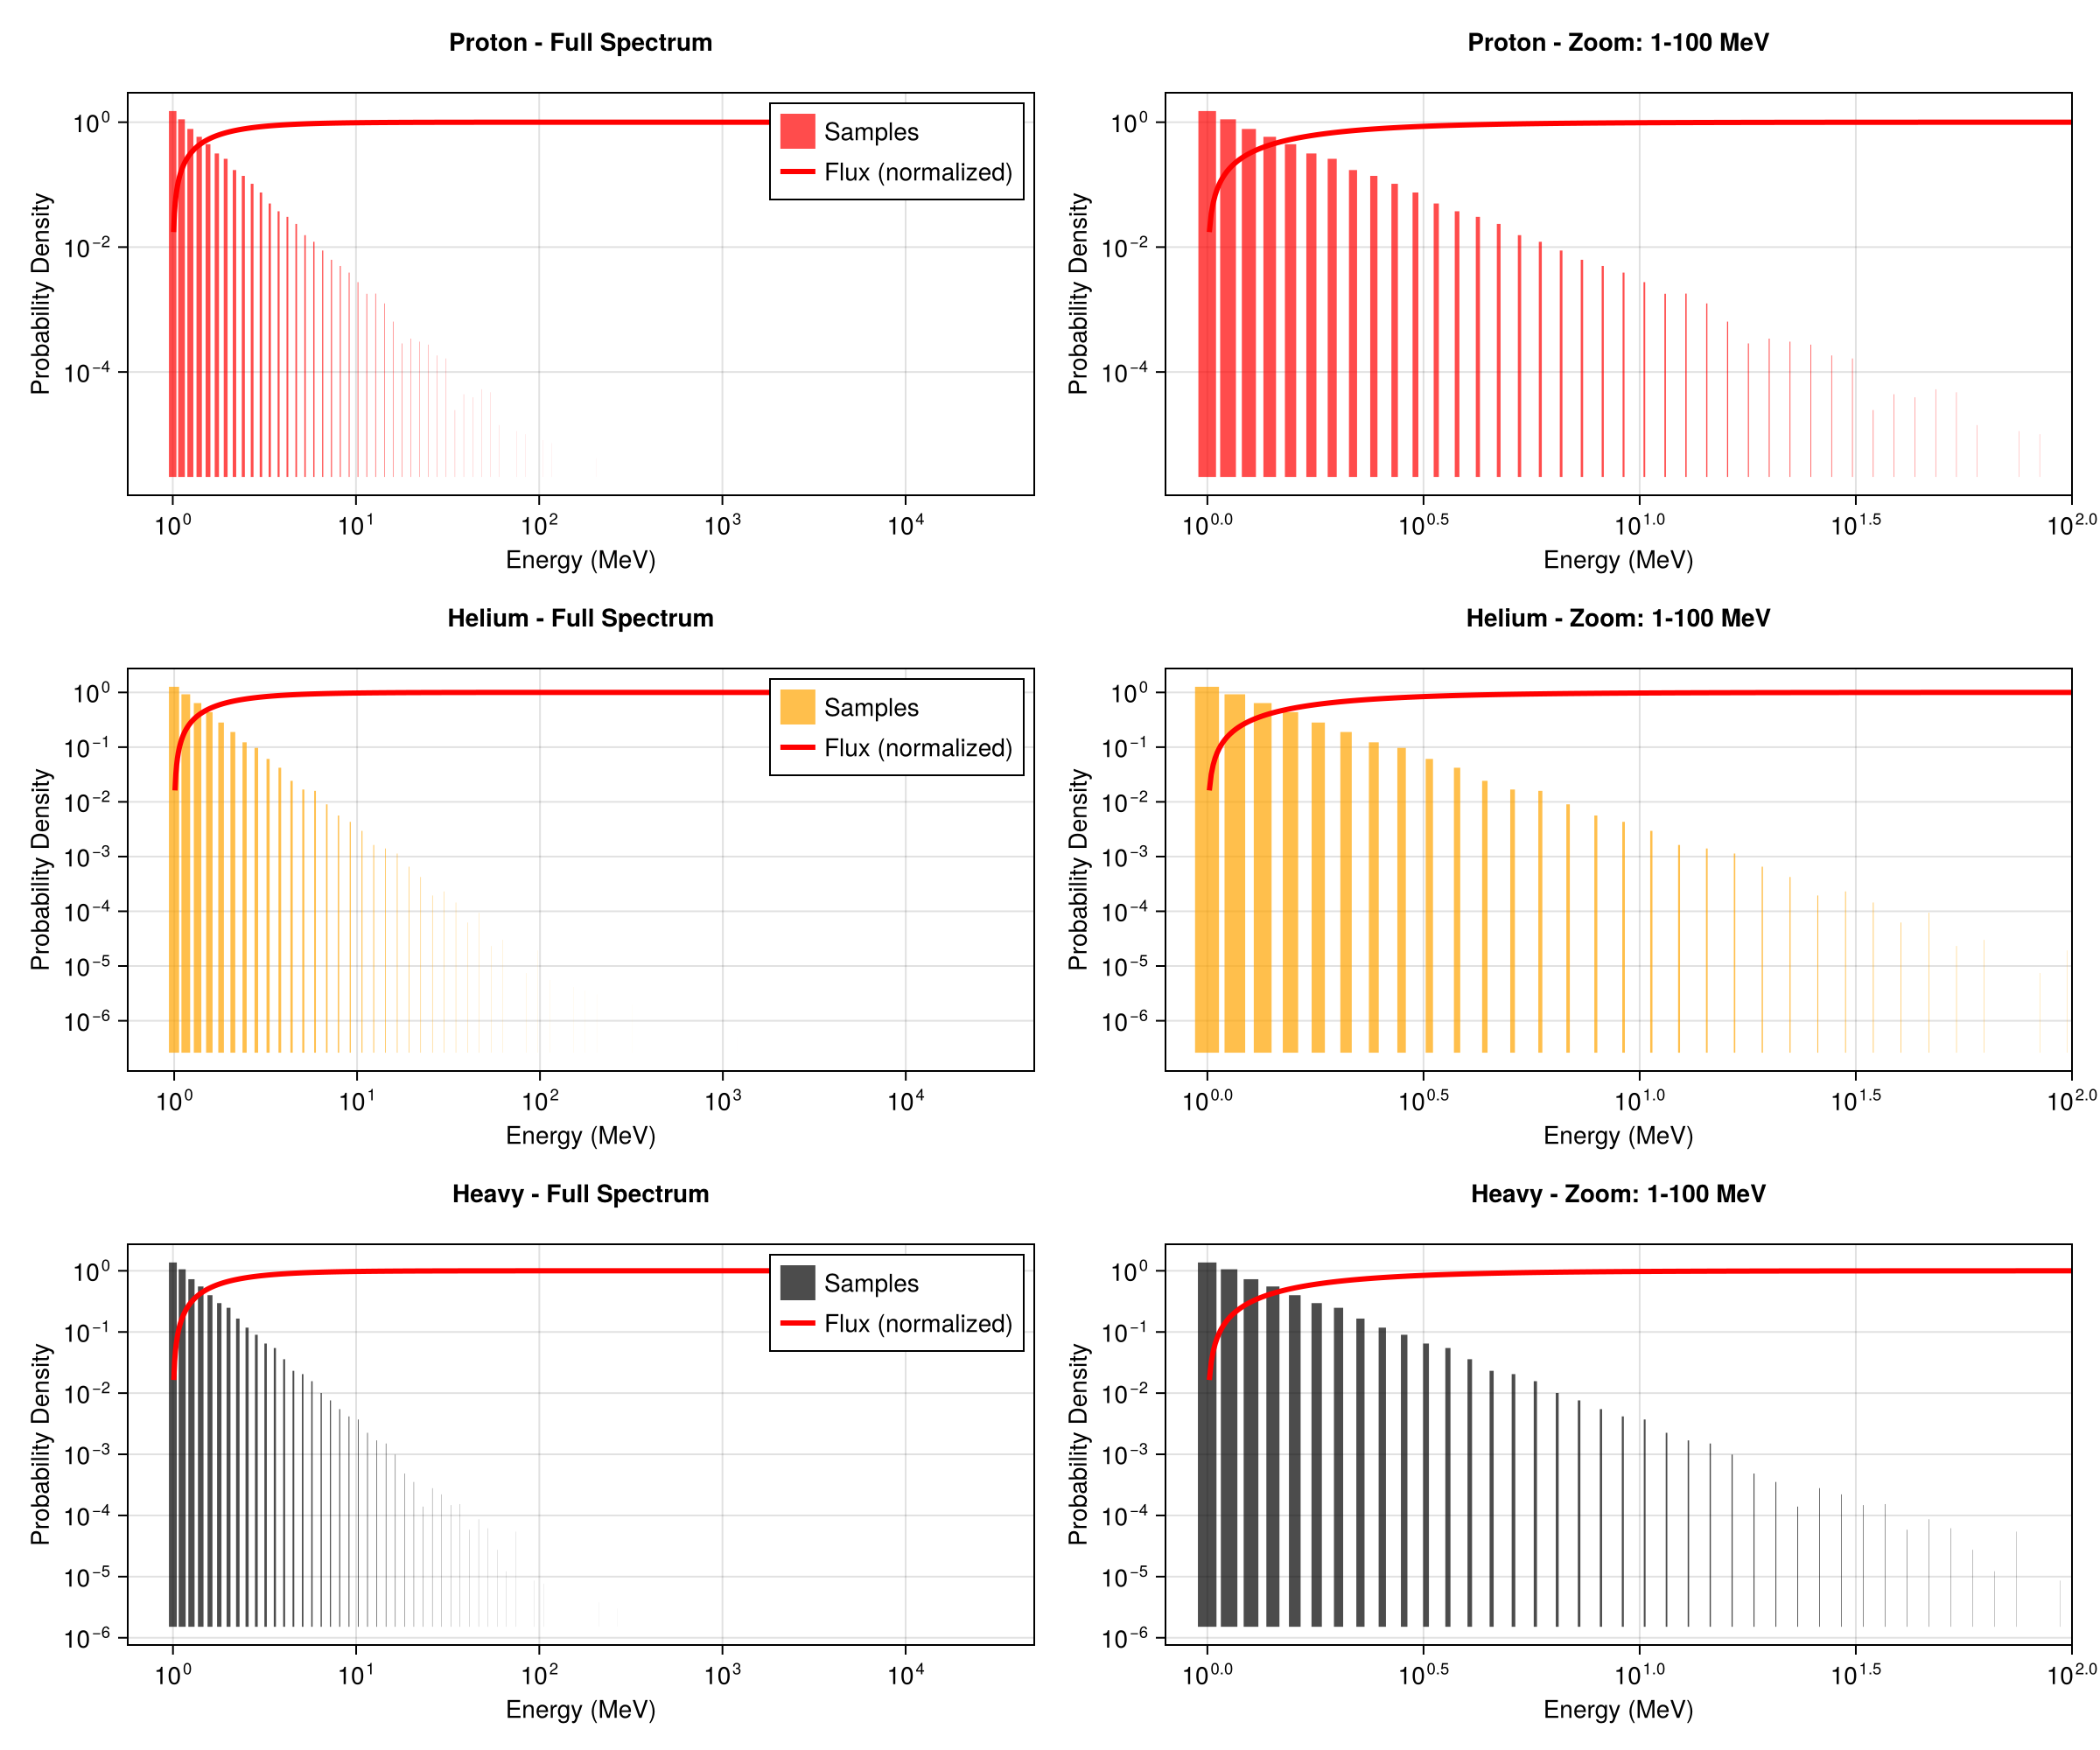

In [75]:
using StatsBase, CairoMakie

# Create figure with 3 rows x 2 columns
fig = Figure(size=(1200, 1000))

particles = [
    (samples=protonenergies, flux=protonfluxCDF, name="Proton", color=:red),
    (samples=heliumenergies, flux=heliumfluxCDF, name="Helium", color=:orange),
    (samples=heavyenergies, flux=heavyfluxCDF, name="Heavy", color=:black)
]

for (i, particle) in enumerate(particles)
    # Logarithmic bin edges for histogram
    log_edges = 10 .^ range(log10(minimum(particle.samples)), log10(maximum(particle.samples)), length=50)
    hist_data = fit(Histogram, particle.samples, log_edges)
    
    # Convert to probability density
    bin_widths = diff(hist_data.edges[1])
    pdf_counts = hist_data.weights ./ (sum(hist_data.weights) .* bin_widths)
    
    # Full spectrum (left column)
    ax1 = Axis(
        fig[i, 1],
        xlabel="Energy (MeV)",
        ylabel="Probability Density", 
        xscale=log10,
        yscale=log10,
        title="$(particle.name) - Full Spectrum",
        titlegap=21
    )
    
    barplot!(
        ax1,
        hist_data.edges[1][1:end-1],
        pdf_counts,
        label="Samples",
        color=particle.color,
        alpha=0.7
    )
    
    lines!(
        ax1,
        energies,
        particle.flux,
        color=:red,
        label="Flux (normalized)",
        linewidth=3
    )
    
    axislegend(ax1)
    
    # Zoomed spectrum 1-100 MeV (right column)
    ax2 = Axis(
        fig[i, 2],
        xlabel="Energy (MeV)",
        ylabel="Probability Density",
        xscale=log10,
        yscale=log10,
        title="$(particle.name) - Zoom: 1-100 MeV",
        titlegap=21,
        limits=((0.8, 1e2), nothing)
    )
    
    barplot!(
        ax2,
        hist_data.edges[1][1:end-1],
        pdf_counts,
        color=particle.color,
        alpha=0.7
    )
    
    lines!(
        ax2,
        energies,
        particle.flux,
        color=:red,
        linewidth=3
    )
end

fig

## Mixed-species sampler

We can now simulate the GCR by sampling weighted on probabilities of interacting with different particle species using the inverse flux CDF derived for each particle using the generalised methods and functions derived above

In [97]:
using Interpolations, Distributions

mutable struct GCRSimulator

    energy_grid::Vector{Float64}
    particles::Vector{Symbol}
    parameters::Dict{Symbol, NamedTuple}
    area::Float64
    fluxes::Vector{Vector{Float64}}
    totalflux::Vector{Float64}
    λ::Float64
    cdfs::Vector{Vector{Float64}}
    inv_cdfs::Vector{Any}

end

function GCRSimulator(parameters::Dict{Symbol, <:NamedTuple};
    E0 = 1.0, Emin = 1.0, Emax = 3.0e4, points = 1000, area = 1.0)

    # hardcoded log-spaced energy grid
    energy_grid = 10 .^ range(log10(Emin), log10(Emax), length=points)
    ΔEs = diff(energy_grid)

    # particle names from parameter keys
    particles = collect(keys(parameters))

    # flux per species and total flux
    fluxes = Vector{Vector{Float64}}(undef, length(particles))
    for (i, particle) in enumerate(particles)
        params = parameters[particle]
        fluxes[i] = params.A .* (energy_grid./E0) .^ (-params.γ) .* exp.(-energy_grid/params.cutoff)
    end
    total_flux = reduce(+, fluxes)

    # trapezoidal integration for flux values
    function trapezoidal(flux)
        return cumsum(0.5 .* (flux[1:end-1] .+ flux[2:end]) .* ΔEs)
    end

    # calculate lambda
    totalfluxint = trapezoidal(total_flux)
    λ = area * 4π * totalfluxint[end]

    # CDFs and inv CDFS

    cdfs = Vector{Vector{Float64}}(undef, length(particles))
    inv_cdfs = Vector{Any}(undef, length(particles))

    for i in 1:length(particles)
        particlefluxint = trapezoidal(fluxes[i])
        particlefluxint = [0.0; particlefluxint]
        cdf = particlefluxint./particlefluxint[end]
        cdfs[i] = cdf
        inv_cdfs[i] = LinearInterpolation(cdf, energy_grid; extrapolation_bc = Throw())
    end

    return GCRSimulator(energy_grid, particles, parameters, area,
                        fluxes, total_flux, λ, cdfs, inv_cdfs)
end

GCRSimulator

In [95]:
using StaticArrays

function simulate_events(sim::GCRSimulator, N::Int)
    
    # arrival times from Poisson process
    Δts = rand(Exponential(1 / sim.λ), N)
    times = cumsum(Δts)

    # output arrays
    species    = Vector{Symbol}(undef, N)
    energies   = Vector{Float64}(undef, N)
    directions = Vector{SVector{3, Float64}}(undef, N)

    # sample particle types
    weights = [sim.parameters[p].weight for p in sim.particles]
    idxs = sample(1:length(sim.particles), Weights(weights), N)

    # loop over events
    for i in 1:N
        s_idx = idxs[i]
        species[i]  = sim.particles[s_idx]
        energies[i] = sim.inv_cdfs[s_idx](rand())  # sample from inverse CDF

        # isotropic direction
        ϕ = 2π * rand()
        μ = rand(Uniform(-1, 1))
        θ = acos(μ)
        directions[i] = SVector(sin(θ) * cos(ϕ), sin(θ) * sin(ϕ), cos(θ))
    end

    return times, species, energies, directions
end


simulate_events (generic function with 1 method)

In [98]:
PARTICLE_PARAMS = Dict(
        :proton => (γ = 2.7, cutoff = 1.0e4, A = 1.0, weight = 0.87),
        :helium => (γ = 2.58, cutoff = 1.0e4, A = 0.1, weight = 0.12),
        :heavy => (γ = 2.6, cutoff = 1.0e4, A = 0.01, weight = 0.01),
    )

sim = GCRSimulator(PARTICLE_PARAMS; area=1.0)

times, species, energies, directions = simulate_events(sim, 10)

println("λ = ", sim.λ, " events/s")
println("First 5 events:")
for i in 1:5
    println((times[i], species[i], energies[i], directions[i]))
end

λ = 8.264562861287374 events/s
First 5 events:
(0.005295358165142768, :proton, 1.3253909593902384, [0.7908590170687188, 0.5362382418992914, 0.2949416265057495])
(0.345429939540317, :proton, 1.025737463868154, [0.12271617414848644, 0.476721668150201, -0.8704465473068682])
(0.38462108076940055, :helium, 1.5886680253677503, [0.18173455634247662, 0.8068398434246848, -0.5621227784865449])
(0.4543960100147555, :proton, 2.5210526424956385, [-0.1530335140649415, 0.059992277675112456, 0.9863983324156056])
(0.554602725869081, :proton, 1.00146382304484, [-0.7552590442477538, 0.5958887957029511, -0.27294746607663584])
